In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import os
import warnings
warnings.filterwarnings('ignore')


In [2]:
def remove_file(filename):
    try:
        os.remove(filename)
    except OSError as e:
        print(f"Error removing {filename}: {e}")

In [3]:
def convert_features(input_file):
    df = pd.read_csv(input_file)
    df['Trade Date (US)'] = pd.to_datetime(df['Trade Date (US)'])
    df['Trade Month'] = df['Trade Date (US)'].dt.month
    df['Trade Day'] = df['Trade Date (US)'].dt.day
    df['Trade Year'] = df['Trade Date (US)'].dt.year
    df.drop(columns=['Trade Date (US)'], inplace=True)
    df['Underpriced'] = df['Offer To 1st Close'].apply(lambda x: 1 if x < 0 else 0)
    df.drop(columns=['Offer To 1st Close'], inplace=True)
    return df

df_convert_features = convert_features('bloomberg_data.csv')

In [4]:
def drop_columns(columns,df):
    df = df.drop(columns=columns)
    return df

df_drop_columns = drop_columns(['Issuer Ticker','Issuer Name','Filing Term Price Range','cusip','Priced Range'],df_convert_features)

In [5]:
def encoding(df):
    X = df.drop(columns=['Underpriced'])
    y = df['Underpriced']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fill NaNs in target column
    if y_train.isnull().any() or y_test.isnull().any():
        mean = y_train.mean()
        y_train = y_train.fillna(mean)
        y_test = y_test.fillna(mean)

    # Fill NaNs in features
    for col in X_train.columns:
        if X_train[col].dtype == 'object':
            mode = X_train[col].mode()[0]
            X_train[col] = X_train[col].fillna(mode)
            X_test[col] = X_test[col].fillna(mode)
        else:
            mean = X_train[col].mean()
            X_train[col] = X_train[col].fillna(mean)
            X_test[col] = X_test[col].fillna(mean)


    # Feature groups
    oe_column = ['Trade Month', 'Trade Day', 'Trade Year'] 
    OHE_Column = ['Industry Sector', 'Industry Group', 'Industry Subgroup']
    Scaling_Column = [col for col in X.select_dtypes(exclude=['object']).columns if col not in oe_column]

    # Encoders and scaler
    oe = OrdinalEncoder()
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')  # ignore unseen categories
    ss = StandardScaler()

    # ColumnTransformer
    Preprocess_step = ColumnTransformer(transformers=[
        ('ohe', ohe, OHE_Column),
        ('ss', ss, Scaling_Column),
        ('oe', oe, oe_column)
    ], remainder='passthrough')

    # Fit only on training data
    Preprocess_step.fit(X_train)

    # Transform both sets
    transformed_train = Preprocess_step.transform(X_train)
    transformed_test = Preprocess_step.transform(X_test)

    # Get new feature names
    features = Preprocess_step.get_feature_names_out()

    # Create transformed dataframes
    df_train = pd.DataFrame(transformed_train, columns=features)
    df_test = pd.DataFrame(transformed_test, columns=features)

    # Add target back
    df_train['Underpriced'] = y_train.reset_index(drop=True)
    df_test['Underpriced'] = y_test.reset_index(drop=True)


    return df_train, df_test

df_train_encoding, df_test_encoding = encoding(df_drop_columns)

/Users/emanuelaromano/Desktop/aml-group17/venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [6]:
def show_correlation(df_train_full,df_test_full):
    X_train = df_train_full.drop(columns=['Underpriced'])
    y_train = df_train_full['Underpriced']

    X_test = df_test_full.drop(columns=['Underpriced'])
    y_test = df_test_full['Underpriced']

    corr_matrix = X_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

    X_reduced = X_train.drop(columns=to_drop)
    X_reduced_test = X_test.drop(columns=to_drop)

    df_train = pd.concat([X_reduced, y_train.reset_index(drop=True)], axis=1)
    df_test = pd.concat([X_reduced_test, y_test.reset_index(drop=True)], axis=1)

    print(f"Removed {len(to_drop)} correlated features.")
    df_test.to_csv('Final_Output_Class_test.csv', index=False)

    return df_train, df_test

df_train_correlation, df_test_correlation = show_correlation(df_train_encoding, df_test_encoding)

Removed 29 correlated features.


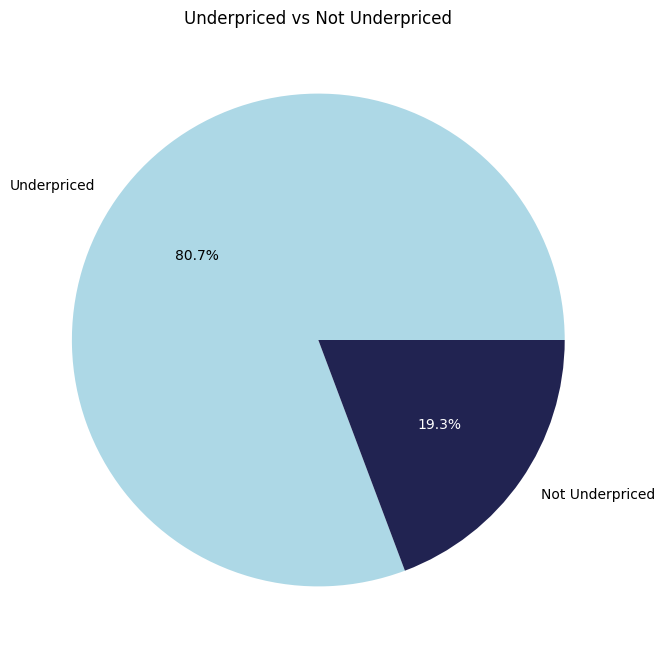

In [7]:
# Load data
df = df_train_correlation.copy()

# Create pie chart showing class imbalance
plt.figure(figsize=(8, 8))
underpriced_counts = df['Underpriced'].value_counts()

# Define labels and colors
labels = ['Underpriced', 'Not Underpriced']
colors = ['lightblue', '#212351']

# Create pie chart and get the texts and autotexts for customization
wedges, texts, autotexts = plt.pie(
    underpriced_counts, labels=labels, colors=colors,
    autopct='%1.1f%%', textprops={'color': 'black'}
)

# Change the color of percentage text based on the wedge color
for i, autotext in enumerate(autotexts):
    if colors[i] == '#212351':
        autotext.set_color('white')

plt.title('Underpriced vs Not Underpriced')
plt.show()


In [8]:
def checkimbalance(df, outfile):
    X_train = df.drop(columns=['Underpriced'])
    y_train = df['Underpriced']

    # Check class distribution
    label_count = y_train.value_counts(normalize=True)
    print(f"Class distribution:\n{label_count}\n")

    # Check for imbalance
    imbalance = abs(label_count[0] - 0.5) > 0.1

    if imbalance:
        print('The data is imbalanced. Applying SMOTE...')
        sampler = SMOTE(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        df_final = pd.concat([X_resampled, y_resampled], axis=1)
        df_final.to_csv(outfile, index=False)
        print(f'The initial dataset had {y_train.shape[0]} rows')
        print(f'The resampled dataset has {y_resampled.shape[0]} rows')
        print(f'Resampled feature matrix shape: {X_resampled.shape}')
        return df_final
    else:
        print('The data is balanced. No resampling applied.')
        return df

df_train_resampled = checkimbalance(df_train_correlation, 'Final_Output_Class_train.csv')

Class distribution:
Underpriced
0    0.807161
1    0.192839
Name: proportion, dtype: float64

The data is imbalanced. Applying SMOTE...
The initial dataset had 3184 rows
The resampled dataset has 5140 rows
Resampled feature matrix shape: (5140, 387)
